In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA], #, model.d_optQ
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:19.0000 R:19.0000 rate:0.0380 gloss:1.3581 dlossA:1.3684 dlossQ:0.4482 exploreP:0.9981
Episode:1 meanR:20.0000 R:21.0000 rate:0.0420 gloss:1.3553 dlossA:1.3688 dlossQ:0.4448 exploreP:0.9960
Episode:2 meanR:24.6667 R:34.0000 rate:0.0680 gloss:1.3514 dlossA:1.3624 dlossQ:0.4430 exploreP:0.9927
Episode:3 meanR:22.0000 R:14.0000 rate:0.0280 gloss:1.3467 dlossA:1.3580 dlossQ:0.4459 exploreP:0.9913
Episode:4 meanR:22.0000 R:22.0000 rate:0.0440 gloss:1.3439 dlossA:1.3552 dlossQ:0.4243 exploreP:0.9892
Episode:5 meanR:20.1667 R:11.0000 rate:0.0220 gloss:1.3377 dlossA:1.3494 dlossQ:0.4213 exploreP:0.9881
Episode:6 meanR:19.7143 R:17.0000 rate:0.0340 gloss:1.3421 dlossA:1.3547 dlossQ:0.4152 exploreP:0.9864
Episode:7 meanR:18.6250 R:11.0000 rate:0.0220 gloss:1.3482 dlossA:1.3587 dlossQ:0.4081 exploreP:0.9854
Episode:8 meanR:18.3333 R:16.0000 rate:0.0320 gloss:1.3388 dlossA:1.3501 dlossQ:0.4116 exploreP:0.9838
Episode:9 meanR:18.5000 R:20.0000 rate:0.0400 gloss:1.3315 dlossA:1.3418 

Episode:79 meanR:22.3000 R:26.0000 rate:0.0520 gloss:1.3209 dlossA:1.3211 dlossQ:0.5084 exploreP:0.8382
Episode:80 meanR:22.1975 R:14.0000 rate:0.0280 gloss:1.3229 dlossA:1.3232 dlossQ:0.5112 exploreP:0.8371
Episode:81 meanR:22.2561 R:27.0000 rate:0.0540 gloss:1.3250 dlossA:1.3251 dlossQ:0.5072 exploreP:0.8349
Episode:82 meanR:22.1687 R:15.0000 rate:0.0300 gloss:1.3190 dlossA:1.3191 dlossQ:0.5097 exploreP:0.8336
Episode:83 meanR:22.2619 R:30.0000 rate:0.0600 gloss:1.3159 dlossA:1.3162 dlossQ:0.5099 exploreP:0.8311
Episode:84 meanR:22.1765 R:15.0000 rate:0.0300 gloss:1.3223 dlossA:1.3224 dlossQ:0.5049 exploreP:0.8299
Episode:85 meanR:22.1047 R:16.0000 rate:0.0320 gloss:1.3167 dlossA:1.3169 dlossQ:0.5095 exploreP:0.8286
Episode:86 meanR:21.9425 R:8.0000 rate:0.0160 gloss:1.3176 dlossA:1.3180 dlossQ:0.5047 exploreP:0.8280
Episode:87 meanR:22.0227 R:29.0000 rate:0.0580 gloss:1.3178 dlossA:1.3179 dlossQ:0.5081 exploreP:0.8256
Episode:88 meanR:22.2360 R:41.0000 rate:0.0820 gloss:1.3164 dloss

Episode:158 meanR:20.3800 R:19.0000 rate:0.0380 gloss:1.3179 dlossA:1.3179 dlossQ:0.5181 exploreP:0.7204
Episode:159 meanR:20.4000 R:20.0000 rate:0.0400 gloss:1.3165 dlossA:1.3165 dlossQ:0.5177 exploreP:0.7190
Episode:160 meanR:20.5500 R:30.0000 rate:0.0600 gloss:1.3150 dlossA:1.3150 dlossQ:0.5201 exploreP:0.7168
Episode:161 meanR:20.6800 R:22.0000 rate:0.0440 gloss:1.3269 dlossA:1.3268 dlossQ:0.5122 exploreP:0.7153
Episode:162 meanR:20.6300 R:19.0000 rate:0.0380 gloss:1.3233 dlossA:1.3232 dlossQ:0.5165 exploreP:0.7139
Episode:163 meanR:20.4900 R:12.0000 rate:0.0240 gloss:1.3158 dlossA:1.3159 dlossQ:0.5176 exploreP:0.7131
Episode:164 meanR:20.2200 R:18.0000 rate:0.0360 gloss:1.3176 dlossA:1.3175 dlossQ:0.5180 exploreP:0.7118
Episode:165 meanR:20.2200 R:13.0000 rate:0.0260 gloss:1.3181 dlossA:1.3181 dlossQ:0.5228 exploreP:0.7109
Episode:166 meanR:20.1600 R:11.0000 rate:0.0220 gloss:1.3243 dlossA:1.3244 dlossQ:0.5207 exploreP:0.7102
Episode:167 meanR:20.0700 R:13.0000 rate:0.0260 gloss:1

Episode:237 meanR:16.2800 R:15.0000 rate:0.0300 gloss:1.3212 dlossA:1.3213 dlossQ:0.5171 exploreP:0.6383
Episode:238 meanR:16.1400 R:12.0000 rate:0.0240 gloss:1.3239 dlossA:1.3239 dlossQ:0.5200 exploreP:0.6375
Episode:239 meanR:16.0500 R:13.0000 rate:0.0260 gloss:1.3224 dlossA:1.3224 dlossQ:0.5183 exploreP:0.6367
Episode:240 meanR:16.0100 R:19.0000 rate:0.0380 gloss:1.3212 dlossA:1.3212 dlossQ:0.5198 exploreP:0.6355
Episode:241 meanR:15.8900 R:11.0000 rate:0.0220 gloss:1.3172 dlossA:1.3171 dlossQ:0.5243 exploreP:0.6348
Episode:242 meanR:15.8400 R:12.0000 rate:0.0240 gloss:1.3251 dlossA:1.3252 dlossQ:0.5217 exploreP:0.6341
Episode:243 meanR:15.8000 R:9.0000 rate:0.0180 gloss:1.3242 dlossA:1.3243 dlossQ:0.5546 exploreP:0.6335
Episode:244 meanR:15.8300 R:16.0000 rate:0.0320 gloss:1.3241 dlossA:1.3241 dlossQ:0.5222 exploreP:0.6325
Episode:245 meanR:15.5500 R:13.0000 rate:0.0260 gloss:1.3194 dlossA:1.3194 dlossQ:0.5220 exploreP:0.6317
Episode:246 meanR:15.4800 R:13.0000 rate:0.0260 gloss:1.

Episode:316 meanR:13.6000 R:12.0000 rate:0.0240 gloss:1.3169 dlossA:1.3168 dlossQ:0.5263 exploreP:0.5751
Episode:317 meanR:13.6000 R:11.0000 rate:0.0220 gloss:1.3128 dlossA:1.3127 dlossQ:0.5260 exploreP:0.5745
Episode:318 meanR:13.6300 R:14.0000 rate:0.0280 gloss:1.3244 dlossA:1.3247 dlossQ:0.5757 exploreP:0.5737
Episode:319 meanR:13.6700 R:14.0000 rate:0.0280 gloss:1.3227 dlossA:1.3227 dlossQ:0.5228 exploreP:0.5729
Episode:320 meanR:13.7200 R:16.0000 rate:0.0320 gloss:1.3178 dlossA:1.3178 dlossQ:0.5249 exploreP:0.5720
Episode:321 meanR:13.6700 R:10.0000 rate:0.0200 gloss:1.3162 dlossA:1.3163 dlossQ:0.5251 exploreP:0.5714
Episode:322 meanR:13.6800 R:12.0000 rate:0.0240 gloss:1.3247 dlossA:1.3248 dlossQ:0.5240 exploreP:0.5708
Episode:323 meanR:13.5600 R:11.0000 rate:0.0220 gloss:1.3188 dlossA:1.3189 dlossQ:0.5209 exploreP:0.5702
Episode:324 meanR:13.5300 R:10.0000 rate:0.0200 gloss:1.3160 dlossA:1.3160 dlossQ:0.5257 exploreP:0.5696
Episode:325 meanR:13.5800 R:16.0000 rate:0.0320 gloss:1

Episode:395 meanR:12.5200 R:9.0000 rate:0.0180 gloss:1.3238 dlossA:1.3240 dlossQ:0.5268 exploreP:0.5226
Episode:396 meanR:12.5300 R:13.0000 rate:0.0260 gloss:1.3128 dlossA:1.3127 dlossQ:0.5293 exploreP:0.5219
Episode:397 meanR:12.5200 R:11.0000 rate:0.0220 gloss:1.3187 dlossA:1.3188 dlossQ:0.5327 exploreP:0.5213
Episode:398 meanR:12.5700 R:18.0000 rate:0.0360 gloss:1.3255 dlossA:1.3256 dlossQ:0.5313 exploreP:0.5204
Episode:399 meanR:12.5600 R:10.0000 rate:0.0200 gloss:1.3160 dlossA:1.3159 dlossQ:0.5289 exploreP:0.5199
Episode:400 meanR:12.5500 R:10.0000 rate:0.0200 gloss:1.3248 dlossA:1.3250 dlossQ:0.5241 exploreP:0.5194
Episode:401 meanR:12.5400 R:12.0000 rate:0.0240 gloss:1.3224 dlossA:1.3224 dlossQ:0.5271 exploreP:0.5188
Episode:402 meanR:12.5000 R:9.0000 rate:0.0180 gloss:1.3261 dlossA:1.3262 dlossQ:0.5242 exploreP:0.5183
Episode:403 meanR:12.4500 R:13.0000 rate:0.0260 gloss:1.3255 dlossA:1.3256 dlossQ:0.5265 exploreP:0.5177
Episode:404 meanR:12.3200 R:11.0000 rate:0.0220 gloss:1.3

Episode:474 meanR:12.3900 R:14.0000 rate:0.0280 gloss:1.3221 dlossA:1.3221 dlossQ:0.5248 exploreP:0.4741
Episode:475 meanR:12.4100 R:12.0000 rate:0.0240 gloss:1.3210 dlossA:1.3211 dlossQ:0.5245 exploreP:0.4735
Episode:476 meanR:12.4100 R:11.0000 rate:0.0220 gloss:1.3110 dlossA:1.3110 dlossQ:0.5223 exploreP:0.4730
Episode:477 meanR:12.4700 R:15.0000 rate:0.0300 gloss:1.3193 dlossA:1.3193 dlossQ:0.5186 exploreP:0.4723
Episode:478 meanR:12.4300 R:9.0000 rate:0.0180 gloss:1.3028 dlossA:1.3027 dlossQ:0.5306 exploreP:0.4719
Episode:479 meanR:12.4200 R:9.0000 rate:0.0180 gloss:1.3280 dlossA:1.3282 dlossQ:0.5238 exploreP:0.4715
Episode:480 meanR:12.4000 R:10.0000 rate:0.0200 gloss:1.3213 dlossA:1.3214 dlossQ:0.5227 exploreP:0.4710
Episode:481 meanR:12.3900 R:9.0000 rate:0.0180 gloss:1.3246 dlossA:1.3248 dlossQ:0.5235 exploreP:0.4706
Episode:482 meanR:12.3700 R:13.0000 rate:0.0260 gloss:1.3218 dlossA:1.3218 dlossQ:0.5216 exploreP:0.4700
Episode:483 meanR:12.3800 R:15.0000 rate:0.0300 gloss:1.31

Episode:553 meanR:12.4900 R:9.0000 rate:0.0180 gloss:1.3380 dlossA:1.3391 dlossQ:0.5653 exploreP:0.4319
Episode:554 meanR:12.4500 R:13.0000 rate:0.0260 gloss:1.3220 dlossA:1.3220 dlossQ:0.5205 exploreP:0.4313
Episode:555 meanR:12.4500 R:12.0000 rate:0.0240 gloss:1.3149 dlossA:1.3147 dlossQ:0.5250 exploreP:0.4308
Episode:556 meanR:12.4700 R:12.0000 rate:0.0240 gloss:1.3260 dlossA:1.3261 dlossQ:0.5236 exploreP:0.4303
Episode:557 meanR:12.4700 R:12.0000 rate:0.0240 gloss:1.3197 dlossA:1.3198 dlossQ:0.5219 exploreP:0.4298
Episode:558 meanR:12.3800 R:10.0000 rate:0.0200 gloss:1.3166 dlossA:1.3167 dlossQ:0.5204 exploreP:0.4294
Episode:559 meanR:12.3500 R:13.0000 rate:0.0260 gloss:1.3188 dlossA:1.3189 dlossQ:0.5270 exploreP:0.4288
Episode:560 meanR:12.3300 R:13.0000 rate:0.0260 gloss:1.3142 dlossA:1.3141 dlossQ:0.5219 exploreP:0.4283
Episode:561 meanR:12.3000 R:13.0000 rate:0.0260 gloss:1.3123 dlossA:1.3125 dlossQ:0.5280 exploreP:0.4278
Episode:562 meanR:12.3700 R:17.0000 rate:0.0340 gloss:1.

Episode:632 meanR:13.2700 R:9.0000 rate:0.0180 gloss:1.3138 dlossA:1.3138 dlossQ:0.5308 exploreP:0.3890
Episode:633 meanR:13.2900 R:13.0000 rate:0.0260 gloss:1.3132 dlossA:1.3133 dlossQ:0.5293 exploreP:0.3885
Episode:634 meanR:13.2700 R:9.0000 rate:0.0180 gloss:1.3186 dlossA:1.3187 dlossQ:0.5309 exploreP:0.3882
Episode:635 meanR:13.2900 R:12.0000 rate:0.0240 gloss:1.3138 dlossA:1.3138 dlossQ:0.5248 exploreP:0.3877
Episode:636 meanR:13.3100 R:11.0000 rate:0.0220 gloss:1.3246 dlossA:1.3247 dlossQ:0.5248 exploreP:0.3873
Episode:637 meanR:13.5200 R:32.0000 rate:0.0640 gloss:1.3243 dlossA:1.3245 dlossQ:0.5234 exploreP:0.3861
Episode:638 meanR:13.5400 R:12.0000 rate:0.0240 gloss:1.3116 dlossA:1.3115 dlossQ:0.5221 exploreP:0.3856
Episode:639 meanR:13.5200 R:14.0000 rate:0.0280 gloss:1.3157 dlossA:1.3156 dlossQ:0.5238 exploreP:0.3851
Episode:640 meanR:13.5700 R:13.0000 rate:0.0260 gloss:1.3259 dlossA:1.3259 dlossQ:0.5196 exploreP:0.3846
Episode:641 meanR:13.6100 R:13.0000 rate:0.0260 gloss:1.3

Episode:711 meanR:13.1900 R:11.0000 rate:0.0220 gloss:1.3120 dlossA:1.3119 dlossQ:0.5283 exploreP:0.3524
Episode:712 meanR:13.1800 R:11.0000 rate:0.0220 gloss:1.3114 dlossA:1.3115 dlossQ:0.5429 exploreP:0.3521
Episode:713 meanR:13.1900 R:10.0000 rate:0.0200 gloss:1.3153 dlossA:1.3153 dlossQ:0.5297 exploreP:0.3517
Episode:714 meanR:13.1800 R:9.0000 rate:0.0180 gloss:1.3223 dlossA:1.3224 dlossQ:0.5284 exploreP:0.3514
Episode:715 meanR:13.1800 R:13.0000 rate:0.0260 gloss:1.3210 dlossA:1.3212 dlossQ:0.5404 exploreP:0.3510
Episode:716 meanR:13.1300 R:9.0000 rate:0.0180 gloss:1.3248 dlossA:1.3251 dlossQ:0.5322 exploreP:0.3507
Episode:717 meanR:13.0700 R:11.0000 rate:0.0220 gloss:1.3226 dlossA:1.3227 dlossQ:0.5264 exploreP:0.3503
Episode:718 meanR:13.0300 R:14.0000 rate:0.0280 gloss:1.3198 dlossA:1.3197 dlossQ:0.5269 exploreP:0.3498
Episode:719 meanR:12.9300 R:17.0000 rate:0.0340 gloss:1.3090 dlossA:1.3088 dlossQ:0.5305 exploreP:0.3492
Episode:720 meanR:12.9700 R:17.0000 rate:0.0340 gloss:1.3

Episode:790 meanR:11.6800 R:9.0000 rate:0.0180 gloss:1.3179 dlossA:1.3180 dlossQ:0.5272 exploreP:0.3222
Episode:791 meanR:11.7400 R:18.0000 rate:0.0360 gloss:1.3190 dlossA:1.3191 dlossQ:0.5236 exploreP:0.3216
Episode:792 meanR:11.7100 R:8.0000 rate:0.0160 gloss:1.3242 dlossA:1.3241 dlossQ:0.5188 exploreP:0.3214
Episode:793 meanR:11.6900 R:11.0000 rate:0.0220 gloss:1.3268 dlossA:1.3270 dlossQ:0.5259 exploreP:0.3210
Episode:794 meanR:11.7100 R:11.0000 rate:0.0220 gloss:1.3132 dlossA:1.3130 dlossQ:0.5296 exploreP:0.3207
Episode:795 meanR:11.7300 R:12.0000 rate:0.0240 gloss:1.3265 dlossA:1.3268 dlossQ:0.5292 exploreP:0.3203
Episode:796 meanR:11.6500 R:10.0000 rate:0.0200 gloss:1.3186 dlossA:1.3186 dlossQ:0.5214 exploreP:0.3200
Episode:797 meanR:11.6400 R:10.0000 rate:0.0200 gloss:1.3240 dlossA:1.3241 dlossQ:0.5232 exploreP:0.3197
Episode:798 meanR:11.6300 R:9.0000 rate:0.0180 gloss:1.3117 dlossA:1.3116 dlossQ:0.5248 exploreP:0.3194
Episode:799 meanR:11.5900 R:13.0000 rate:0.0260 gloss:1.31

Episode:869 meanR:11.1800 R:10.0000 rate:0.0200 gloss:1.3115 dlossA:1.3114 dlossQ:0.5279 exploreP:0.2957
Episode:870 meanR:11.1900 R:11.0000 rate:0.0220 gloss:1.3179 dlossA:1.3178 dlossQ:0.5291 exploreP:0.2953
Episode:871 meanR:11.1900 R:11.0000 rate:0.0220 gloss:1.3087 dlossA:1.3085 dlossQ:0.5274 exploreP:0.2950
Episode:872 meanR:11.2200 R:13.0000 rate:0.0260 gloss:1.3097 dlossA:1.3097 dlossQ:0.5318 exploreP:0.2947
Episode:873 meanR:11.3100 R:18.0000 rate:0.0360 gloss:1.3134 dlossA:1.3133 dlossQ:0.5310 exploreP:0.2942
Episode:874 meanR:11.3000 R:10.0000 rate:0.0200 gloss:1.3130 dlossA:1.3130 dlossQ:0.5283 exploreP:0.2939
Episode:875 meanR:11.2900 R:11.0000 rate:0.0220 gloss:1.3170 dlossA:1.3171 dlossQ:0.5255 exploreP:0.2936
Episode:876 meanR:11.2700 R:9.0000 rate:0.0180 gloss:1.3125 dlossA:1.3124 dlossQ:0.5318 exploreP:0.2933
Episode:877 meanR:11.2900 R:10.0000 rate:0.0200 gloss:1.3056 dlossA:1.3054 dlossQ:0.5301 exploreP:0.2930
Episode:878 meanR:11.2800 R:9.0000 rate:0.0180 gloss:1.3

Episode:948 meanR:11.1000 R:10.0000 rate:0.0200 gloss:1.3108 dlossA:1.3107 dlossQ:0.5276 exploreP:0.2716
Episode:949 meanR:11.1500 R:13.0000 rate:0.0260 gloss:1.3108 dlossA:1.3108 dlossQ:0.5298 exploreP:0.2713
Episode:950 meanR:11.1800 R:12.0000 rate:0.0240 gloss:1.3124 dlossA:1.3124 dlossQ:0.5291 exploreP:0.2709
Episode:951 meanR:11.1800 R:10.0000 rate:0.0200 gloss:1.3286 dlossA:1.3287 dlossQ:0.5211 exploreP:0.2707
Episode:952 meanR:11.1700 R:9.0000 rate:0.0180 gloss:1.3156 dlossA:1.3157 dlossQ:0.5270 exploreP:0.2704
Episode:953 meanR:11.2100 R:15.0000 rate:0.0300 gloss:1.3180 dlossA:1.3181 dlossQ:0.5248 exploreP:0.2701
Episode:954 meanR:11.2100 R:10.0000 rate:0.0200 gloss:1.3140 dlossA:1.3141 dlossQ:0.5295 exploreP:0.2698
Episode:955 meanR:11.1700 R:10.0000 rate:0.0200 gloss:1.3130 dlossA:1.3129 dlossQ:0.5255 exploreP:0.2695
Episode:956 meanR:11.1200 R:13.0000 rate:0.0260 gloss:1.3202 dlossA:1.3201 dlossQ:0.5225 exploreP:0.2692
Episode:957 meanR:11.0900 R:10.0000 rate:0.0200 gloss:1.

Episode:1026 meanR:10.6700 R:9.0000 rate:0.0180 gloss:1.3198 dlossA:1.3198 dlossQ:0.5198 exploreP:0.2509
Episode:1027 meanR:10.6500 R:10.0000 rate:0.0200 gloss:1.3176 dlossA:1.3175 dlossQ:0.5244 exploreP:0.2507
Episode:1028 meanR:10.6400 R:11.0000 rate:0.0220 gloss:1.3125 dlossA:1.3125 dlossQ:0.5226 exploreP:0.2504
Episode:1029 meanR:10.6600 R:12.0000 rate:0.0240 gloss:1.3140 dlossA:1.3139 dlossQ:0.5280 exploreP:0.2501
Episode:1030 meanR:10.6400 R:8.0000 rate:0.0160 gloss:1.3103 dlossA:1.3103 dlossQ:0.5288 exploreP:0.2499
Episode:1031 meanR:10.8200 R:30.0000 rate:0.0600 gloss:1.3135 dlossA:1.3134 dlossQ:0.5266 exploreP:0.2492
Episode:1032 meanR:10.7900 R:10.0000 rate:0.0200 gloss:1.3188 dlossA:1.3188 dlossQ:0.5251 exploreP:0.2490
Episode:1033 meanR:10.7900 R:10.0000 rate:0.0200 gloss:1.3080 dlossA:1.3078 dlossQ:0.5275 exploreP:0.2487
Episode:1034 meanR:10.7800 R:9.0000 rate:0.0180 gloss:1.3172 dlossA:1.3174 dlossQ:0.5294 exploreP:0.2485
Episode:1035 meanR:10.7700 R:12.0000 rate:0.0240 

Episode:1104 meanR:10.6800 R:13.0000 rate:0.0260 gloss:1.3169 dlossA:1.3168 dlossQ:0.5263 exploreP:0.2315
Episode:1105 meanR:10.6900 R:12.0000 rate:0.0240 gloss:1.3112 dlossA:1.3111 dlossQ:0.5276 exploreP:0.2313
Episode:1106 meanR:10.7200 R:12.0000 rate:0.0240 gloss:1.3183 dlossA:1.3182 dlossQ:0.5246 exploreP:0.2310
Episode:1107 meanR:10.7500 R:13.0000 rate:0.0260 gloss:1.3189 dlossA:1.3188 dlossQ:0.5236 exploreP:0.2307
Episode:1108 meanR:10.7800 R:12.0000 rate:0.0240 gloss:1.3067 dlossA:1.3068 dlossQ:0.5228 exploreP:0.2304
Episode:1109 meanR:10.7700 R:9.0000 rate:0.0180 gloss:1.3115 dlossA:1.3116 dlossQ:0.5294 exploreP:0.2302
Episode:1110 meanR:10.7600 R:11.0000 rate:0.0220 gloss:1.3295 dlossA:1.3294 dlossQ:0.5201 exploreP:0.2300
Episode:1111 meanR:10.7800 R:13.0000 rate:0.0260 gloss:1.3129 dlossA:1.3129 dlossQ:0.5257 exploreP:0.2297
Episode:1112 meanR:10.8200 R:12.0000 rate:0.0240 gloss:1.3300 dlossA:1.3302 dlossQ:0.5198 exploreP:0.2294
Episode:1113 meanR:10.8200 R:10.0000 rate:0.020

Episode:1182 meanR:10.6800 R:9.0000 rate:0.0180 gloss:1.3171 dlossA:1.3172 dlossQ:0.5288 exploreP:0.2138
Episode:1183 meanR:10.7300 R:13.0000 rate:0.0260 gloss:1.3146 dlossA:1.3144 dlossQ:0.5252 exploreP:0.2135
Episode:1184 meanR:10.7700 R:13.0000 rate:0.0260 gloss:1.3098 dlossA:1.3099 dlossQ:0.5233 exploreP:0.2132
Episode:1185 meanR:10.7500 R:10.0000 rate:0.0200 gloss:1.3226 dlossA:1.3227 dlossQ:0.5242 exploreP:0.2130
Episode:1186 meanR:10.7300 R:10.0000 rate:0.0200 gloss:1.3051 dlossA:1.3050 dlossQ:0.5292 exploreP:0.2128
Episode:1187 meanR:10.7400 R:9.0000 rate:0.0180 gloss:1.3210 dlossA:1.3209 dlossQ:0.5322 exploreP:0.2126
Episode:1188 meanR:10.7300 R:9.0000 rate:0.0180 gloss:1.3170 dlossA:1.3170 dlossQ:0.5234 exploreP:0.2125
Episode:1189 meanR:10.7000 R:10.0000 rate:0.0200 gloss:1.3244 dlossA:1.3247 dlossQ:0.5285 exploreP:0.2123
Episode:1190 meanR:10.6900 R:10.0000 rate:0.0200 gloss:1.3108 dlossA:1.3107 dlossQ:0.5264 exploreP:0.2120
Episode:1191 meanR:10.6900 R:10.0000 rate:0.0200 

Episode:1260 meanR:10.7200 R:11.0000 rate:0.0220 gloss:1.3123 dlossA:1.3124 dlossQ:0.5292 exploreP:0.1974
Episode:1261 meanR:10.7300 R:10.0000 rate:0.0200 gloss:1.3002 dlossA:1.3002 dlossQ:0.5256 exploreP:0.1972
Episode:1262 meanR:10.7100 R:9.0000 rate:0.0180 gloss:1.3160 dlossA:1.3159 dlossQ:0.5263 exploreP:0.1970
Episode:1263 meanR:10.6700 R:12.0000 rate:0.0240 gloss:1.3056 dlossA:1.3055 dlossQ:0.5275 exploreP:0.1968
Episode:1264 meanR:10.6700 R:11.0000 rate:0.0220 gloss:1.3044 dlossA:1.3044 dlossQ:0.5289 exploreP:0.1966
Episode:1265 meanR:10.6500 R:10.0000 rate:0.0200 gloss:1.3155 dlossA:1.3157 dlossQ:0.5265 exploreP:0.1964
Episode:1266 meanR:10.6500 R:11.0000 rate:0.0220 gloss:1.2919 dlossA:1.2918 dlossQ:0.5357 exploreP:0.1962
Episode:1267 meanR:10.6100 R:13.0000 rate:0.0260 gloss:1.3037 dlossA:1.3037 dlossQ:0.5230 exploreP:0.1960
Episode:1268 meanR:10.6200 R:10.0000 rate:0.0200 gloss:1.3167 dlossA:1.3172 dlossQ:0.5380 exploreP:0.1958
Episode:1269 meanR:10.6000 R:8.0000 rate:0.0160

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

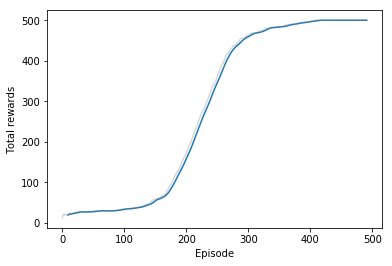

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

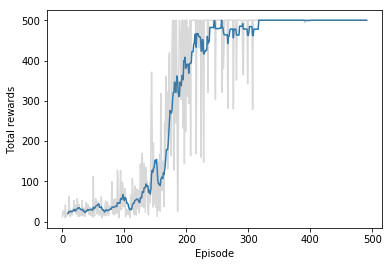

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.